<img src="../logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Trabajo Práctico Nº6
#### Federico Borello

Hago uso de un módulo llamado `pds_utils` ubicado en el directorio base del repositorio

## Windowing - Ventaneo y Estimactión Espectral

La estimación espectral es una técnica fundamental en el análisis de señales, ya que permite obtener información sobre la distribución de energía de una señal en el dominio de la frecuencia. Esta herramienta es esencial para comprender cómo se comportan las señales en diferentes rangos de frecuencia y para identificar componentes frecuenciales significativos.

En este contexto, se proponen dos estimadores: 

1. **Estimador de Magnitud**: Este estimador se obtiene al evaluar la Transformada Rápida de Fourier (FFT) de la señal en $N/4$.

2. **Estimador de Frecuencia**: Este estimador utiliza todos los valores obtenidos a partir de la FFT para estimar la frecuencia real de la señal. Al integrar toda la información disponible, se busca obtener una estimación más precisa y robusta.

Para simular un entorno más realista, se introduce ruido analógico o gaussiano en las señales. Esto permite generar diferentes realizaciones de la señal, lo que a su vez requiere realizar múltiples "experimentos" o "ensayos". A partir de estos ensayos, se calculan valores estadísticos fundamentales como la media, el sesgo y la varianza.

### Implicancia del Sesgo y la Varianza

El sesgo y la varianza son dos conceptos clave que afectan la calidad de un estimador. 

- **Sesgo**: Se refiere a la diferencia entre el valor esperado del estimador y el valor verdadero del parámetro que se está estimando. Un estimador es considerado insesgado si su sesgo es cero, lo que significa que, en promedio, proporciona estimaciones correctas del parámetro. Un sesgo significativo puede llevar a conclusiones erróneas sobre el comportamiento de la señal.

$$
\text{Sesgo}(\theta) = E(T) - \theta
$$

- **Varianza**: Representa la variabilidad de las estimaciones del estimador alrededor de su valor esperado. Un estimador con alta varianza puede producir resultados muy dispersos entre diferentes ensayos, lo que dificulta confiar en su precisión. Por otro lado, un estimador con baja varianza tiende a ser más consistente, lo que es deseable en aplicaciones prácticas.

Al utilizar la media como un valor representativo después de múltiples ensayos, es crucial considerar tanto el sesgo como la varianza del estimador. Un buen balance entre ambos aspectos asegura que las estimaciones sean precisas y confiables, permitiendo así una interpretación adecuada de los resultados obtenidos en el análisis espectral.

### Caso de la Media

Si consideramos la media poblacional $\mu$ como el parámetro a estimar y utilizamos la media muestral $\bar{X}$ como nuestro estimador, el sesgo se puede calcular de la siguiente manera:

$$
\text{Sesgo}(\bar{X}) = E(\bar{X}) - \mu
$$

Esto implica, que si estamos estimando el valor de una señal que **suponemos**, o según las especificaciones del generador de señal debería ser conocido, se puede calcular el sesgo como:

$$
\text{Sesgo}(\bar{X}) = E(\bar{X}) - \text{Valor Real}
$$
 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


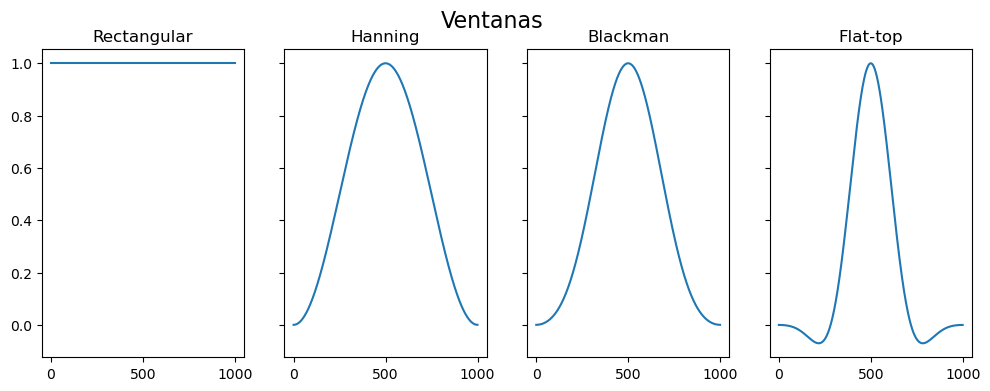

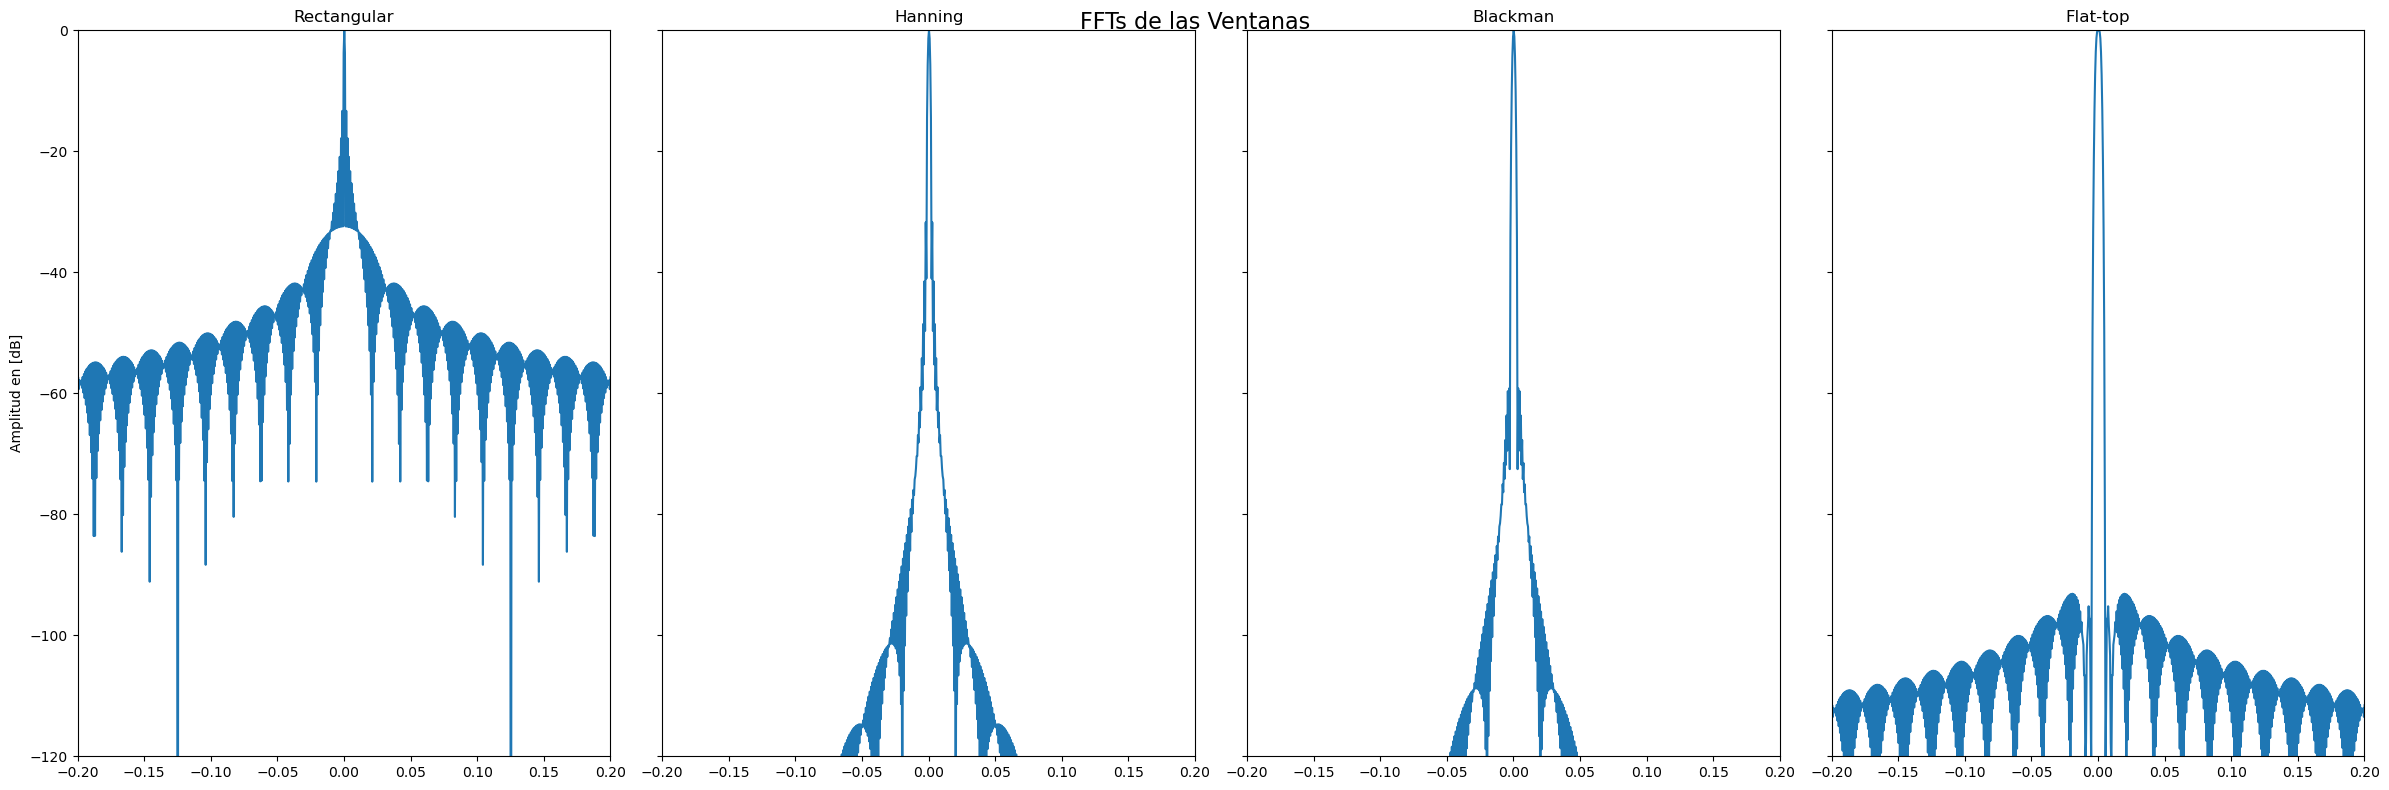

In [1]:
# @title: SetUp
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
from scipy import signal

amplitude = 2

# Señal a cuantizar
fs = N = 1000
spectral_res = fs / N
omega_0 = N / 4
df = fs / N

windows = {
    "Rectangular": signal.windows.boxcar(N),
    "Hanning": signal.windows.hann(N),
    "Blackman": signal.windows.blackman(N),
    "Flat-top": signal.windows.flattop(N),
}

fig_hist, axs_hist = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)

# Ploteo de las ventanas
for i, (name, window) in enumerate(windows.items()):
    axs_hist[i].plot(window)
    axs_hist[i].set_title(name)

fig_hist.suptitle("Ventanas", fontsize=16)
plt.show()

# Ploteo de la FFT de las ventanas
fig_fft, axs_fft = plt.subplots(1, 4, figsize=(24, 8), sharex=True, sharey=True)

# De la documentacion de scipy.signal.windows:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.blackmanharris.html#scipy.signal.windows.blackmanharris
for i, (name, window) in enumerate(windows.items()):
    A = sp.fft.fft(window, 2048) / (len(window) / 2.0)

    # Frequency axis for plotting
    freq = np.linspace(-0.5, 0.5, len(A))

    # Compute the response in dB
    epsilon = 1e-10  # constante pare evitar error de division por cero
    response = 20 * np.log10(np.abs(sp.fft.fftshift(A) / np.max(np.abs(A)) + epsilon))
    # Plotting
    axs_fft[i].plot(freq, response)
    axs_fft[i].set_title(name)
    axs_fft[i].set_ylim([-120, 0])
    axs_fft[i].set_xlim([-0.2, 0.2])


axs_fft[0].set_ylabel("Amplitud en [dB]")
plt.tight_layout()
plt.suptitle("FFTs de las Ventanas", fontsize=16)
plt.show()


## Estimador de Magnitud

En el contexto de la estimación espectral, el estimador de magnitud se utiliza para calcular la magnitud de los componentes espectrales de una señal en una frecuencia específica.

$$\hat{a_i} = \left| X_{i \, , \frac{N}{4}} \right|$$

In [2]:
number_of_experiments = 200

X_3_matrix = np.zeros((number_of_experiments, N), dtype=complex)
X_10_matrix = np.zeros((number_of_experiments, N), dtype=complex)

results_SNR_3 = []
results_SNR_10 = []

# Aplique la ventana a la señal
for window_name, window in windows.items():
    for experiment in range(number_of_experiments):
        frequency_factor = np.random.uniform(low=-2, high=2)
        omega_1 = omega_0 + frequency_factor * df
        f = omega_1
        t = np.arange(N) / fs
        sr = amplitude * np.sin(2 * np.pi * f * t)  # Generate sine wave

        # Add noise to the signal (SNR values)
        snr_10 = 10
        snr_3 = 3
        sigma_n_sq_10 = np.var(sr) / (10 ** (snr_10 / 10))
        sn_10 = sr + np.random.normal(0, np.sqrt(sigma_n_sq_10), N)

        sigma_n_sq_3 = np.var(sr) / (10 ** (snr_3 / 10))
        sn_3 = sr + np.random.normal(0, np.sqrt(sigma_n_sq_3), N)

        X_3 = np.fft.fft(sn_3 * window) / N
        X_3_matrix[experiment, :] += X_3

        X_10 = np.fft.fft(sn_10 * window) / N
        X_10_matrix[experiment, :] += X_10

    # Evaluar la señal en N/4
    X_3_evaluated_at_N_over_4 = 2 * np.abs(X_3_matrix[:, N // 4])
    X_10_evaluated_at_N_over_4 = 2 * np.abs(X_10_matrix[:, N // 4])

    mean_with_snr_3 = np.mean(X_3_evaluated_at_N_over_4)
    mean_with_snr_10 = np.mean(X_10_evaluated_at_N_over_4)

    # Calcular sesgo
    bias_3 = mean_with_snr_3 - amplitude
    corrected_value_3 = mean_with_snr_3 - bias_3

    bias_10 = mean_with_snr_10 - amplitude
    corrected_value_10 = mean_with_snr_10 - bias_10

    # Calcular varianza
    variance_3 = np.var(X_3_evaluated_at_N_over_4)
    variance_10 = np.var(X_10_evaluated_at_N_over_4)

    results_SNR_3.append(
        {
            "Window": window_name,
            "Estimacion": mean_with_snr_3,
            "Estimacion Corregida": corrected_value_3,
            "Signal": X_3_evaluated_at_N_over_4,
            "Sesgo": bias_3,
            "Variance": variance_3,
        }
    )

    results_SNR_10.append(
        {
            "Window": window_name,
            "Estimacion": mean_with_snr_10,
            "Estimacion Corregida": corrected_value_10,
            "Signal": X_10_evaluated_at_N_over_4,
            "Sesgo": bias_10,
            "Varianza": variance_10,
        }
    )

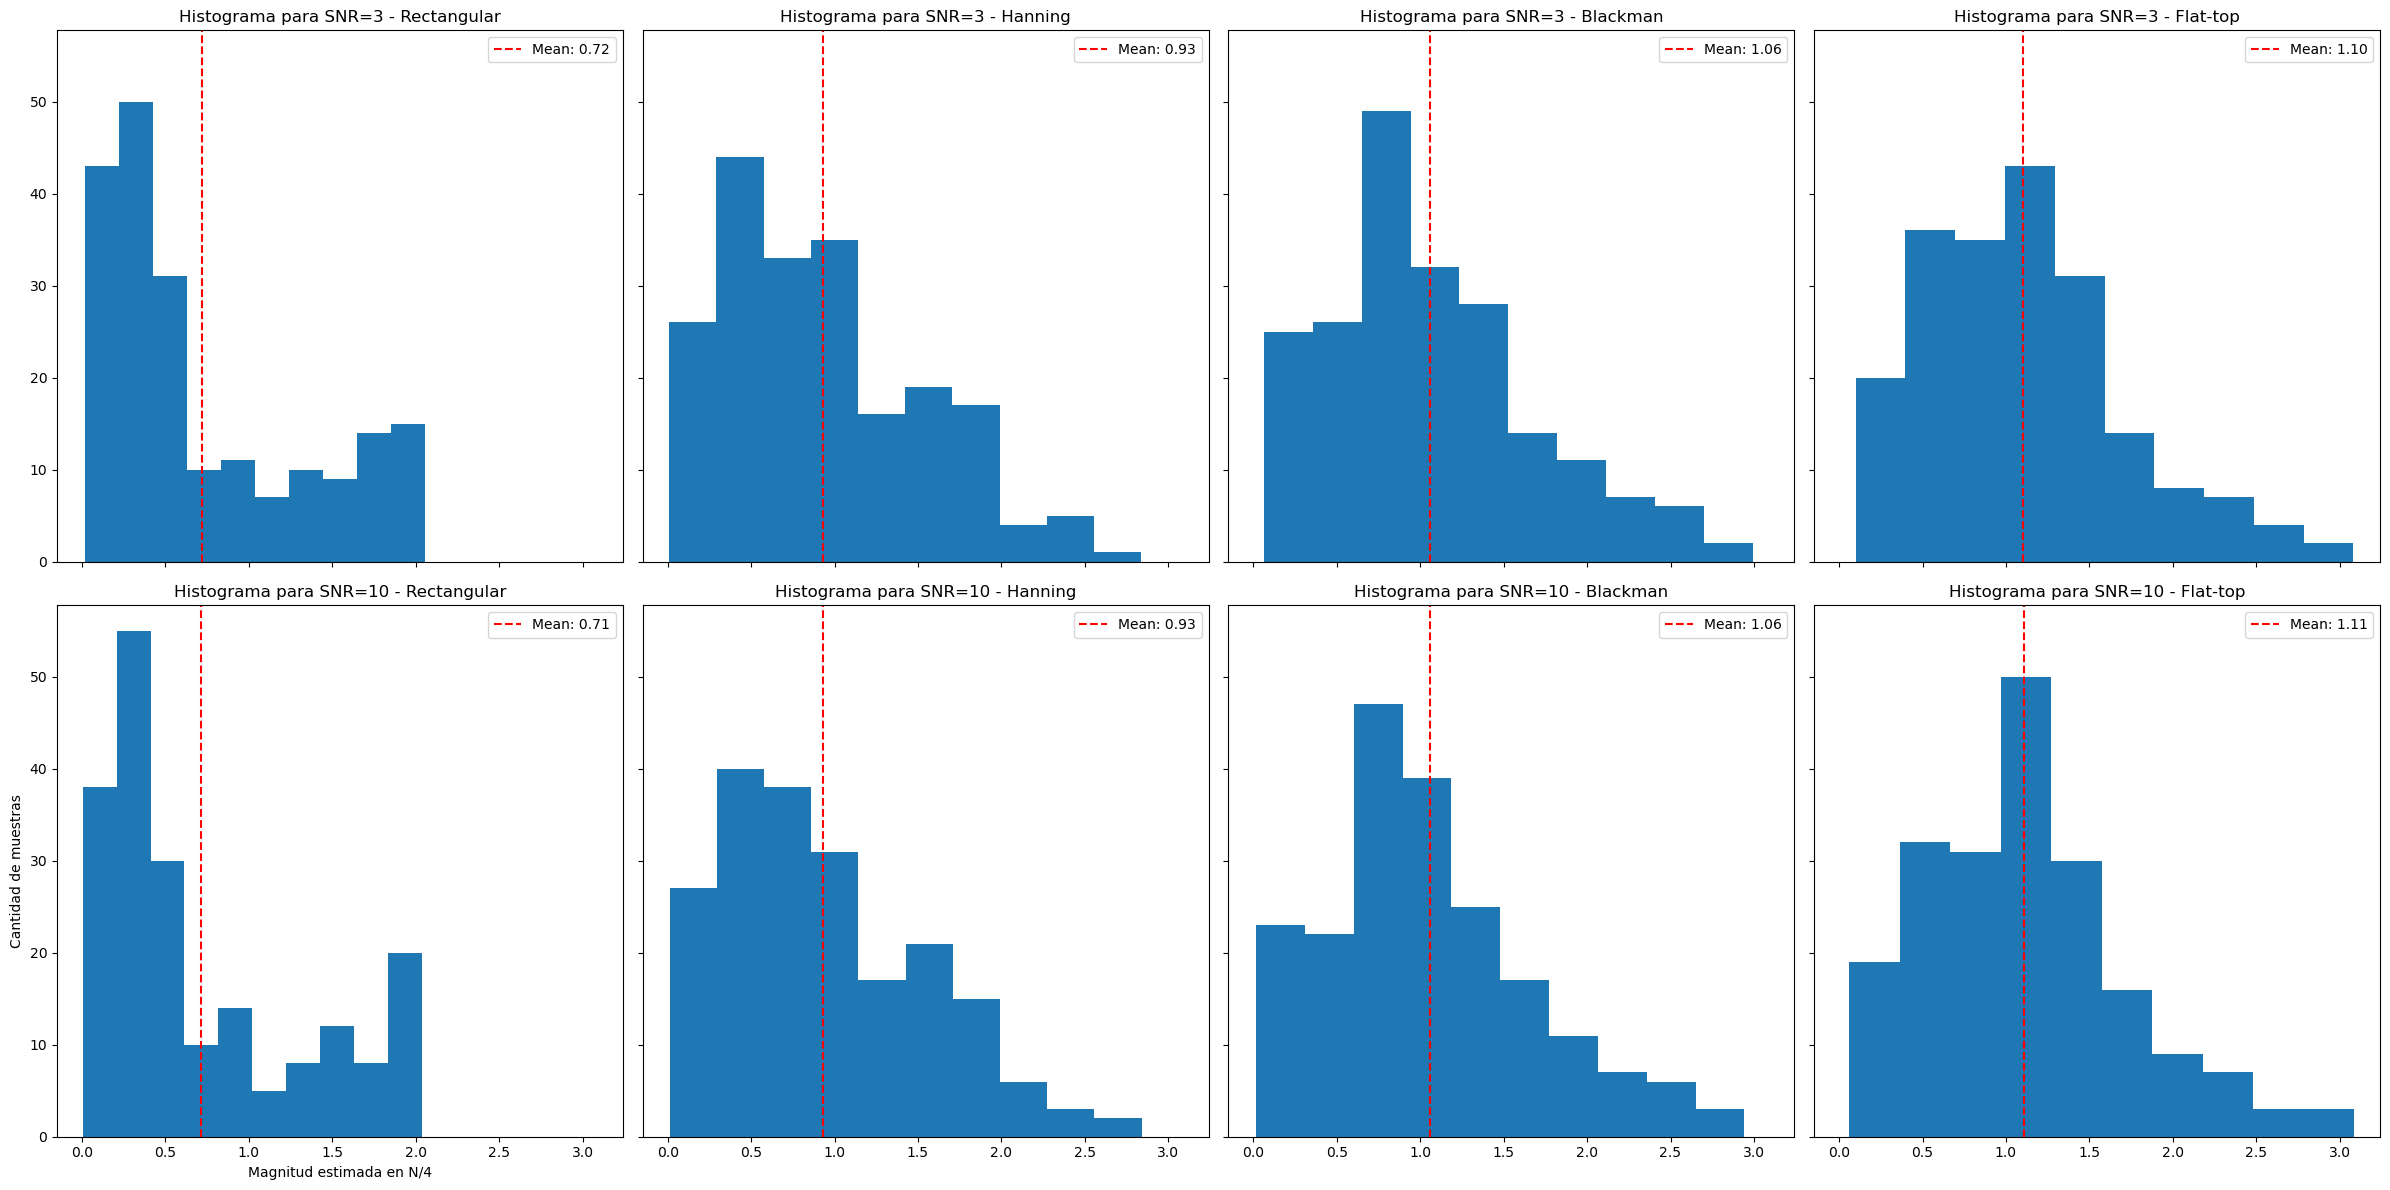

In [3]:
import matplotlib.pyplot as plt

bins = 10

fig_hist, axs_hist = plt.subplots(2, 4, figsize=(24, 12), sharex=True, sharey=True)

# Histogram para SNR=3
for i, result in enumerate(results_SNR_3):
    axs_hist[0, i].hist(result["Signal"], bins=bins)
    axs_hist[0, i].axvline(
        result["Estimacion"],
        color="r",
        linestyle="--",
        label=f"Mean: {result['Estimacion']:.2f}",
    )
    axs_hist[0, i].set_title(f"Histograma para SNR=3 - {result['Window']}")
    axs_hist[0, i].legend()

# Histogram para SNR=10
for i, result in enumerate(results_SNR_10):
    axs_hist[1, i].hist(result["Signal"], bins=bins)
    axs_hist[1, i].axvline(
        result["Estimacion"],
        color="r",
        linestyle="--",
        label=f"Mean: {result['Estimacion']:.2f}",
    )
    axs_hist[1, i].set_title(f"Histograma para SNR=10 - {result['Window']}")
    axs_hist[1, i].legend()

axs_hist[1, 0].set_xlabel("Magnitud estimada en N/4")
axs_hist[1, 0].set_ylabel("Cantidad de muestras")
plt.tight_layout()
plt.show()

## Conclusiones del Histograma

El Histograma muestra que la media está lejos del valor esperado, o el valor real, que sería $2$. Pero intuitivamente se puede ver una mayor cantidad de muestras en torno a $2$. Si se cuenta con una referencia, de que el valor estimado es cercano a $2$ debido a la especificación del generador de señales por ejemplo, se puede decir con seguirdad que la media muestral presenta un sesgo, lo cual se soluciona con una constante como se calculó en la celda anterior.

Además, las ventanas `Hanning`, `Blackman` y `Flat-top` tienen mayor tendencia a $1$, que sería el valor esperado dividido 2.


## Estimador de Fase

$$\hat{\Omega}_1 = arg_{\Omega} \, max \left\{ \left| X_{i \, , \frac{N}{4}} \right| \right\} $$

In [4]:
X_3_matrix = np.zeros((number_of_experiments, N), dtype=complex)
X_10_matrix = np.zeros((number_of_experiments, N), dtype=complex)

results_frq_SNR_3 = []
results_frq_SNR_10 = []

# Aplique la ventana a la señal
for window_name, window in windows.items():
    for experiment in range(number_of_experiments):
        frequency_factor = np.random.uniform(low=-2, high=2)
        omega_1 = omega_0 + frequency_factor * df
        f = omega_1

        t = np.arange(N) / fs
        sr = amplitude * np.sin(2 * np.pi * f * t)  # Generate sine wave

        # Add noise to the signal (SNR values)
        snr_10 = 10
        snr_3 = 3
        sigma_n_sq_10 = np.var(sr) / (10 ** (snr_10 / 10))
        sn_10 = sr + np.random.normal(0, np.sqrt(sigma_n_sq_10), N)

        sigma_n_sq_3 = np.var(sr) / (10 ** (snr_3 / 10))
        sn_3 = sr + np.random.normal(0, np.sqrt(sigma_n_sq_3), N)

        X_3 = np.fft.fft(sn_3 * window) / N
        X_3_matrix[experiment, :] += X_3

        X_10 = np.fft.fft(sn_10 * window) / N
        X_10_matrix[experiment, :] += X_10

    # Se obtiene el estimador de la frecuencia
    arg_max_X_3_evaluated_at_N_over_4 = (
        np.argmax(np.abs(X_3_matrix[:, : N // 2]), axis=1) * df
    )
    arg_max_X_10_evaluated_at_N_over_4 = (
        np.argmax(np.abs(X_10_matrix[:, : N // 2]), axis=1) * df
    )

    # Media
    mean_with_snr_3 = np.mean(arg_max_X_3_evaluated_at_N_over_4)
    mean_with_snr_10 = np.mean(arg_max_X_10_evaluated_at_N_over_4)

    # Sesgo
    bias_3 = mean_with_snr_3 - omega_0
    bias_10 = mean_with_snr_10 - omega_0

    # El valor corregido sería el estimador sesgado menos el sesgo
    corrected_value_3 = mean_with_snr_3 - bias_3
    corrected_value_10 = mean_with_snr_10 - bias_10

    # Varianza
    variance_3 = np.var(arg_max_X_3_evaluated_at_N_over_4)
    variance_10 = np.var(arg_max_X_10_evaluated_at_N_over_4)

    results_frq_SNR_3.append(
        {
            "Window": window_name,
            "Estimacion": mean_with_snr_3,
            "Estimacion Corregida": corrected_value_3,
            "Signal": arg_max_X_3_evaluated_at_N_over_4,
            "Sesgo": bias_3,
            "Variance": variance_3,
        }
    )

    results_frq_SNR_10.append(
        {
            "Window": window_name,
            "Estimacion": mean_with_snr_10,
            "Estimacion Corregida": corrected_value_10,
            "Signal": arg_max_X_10_evaluated_at_N_over_4,
            "Sesgo": bias_10,
            "Varianza": variance_10,
        }
    )

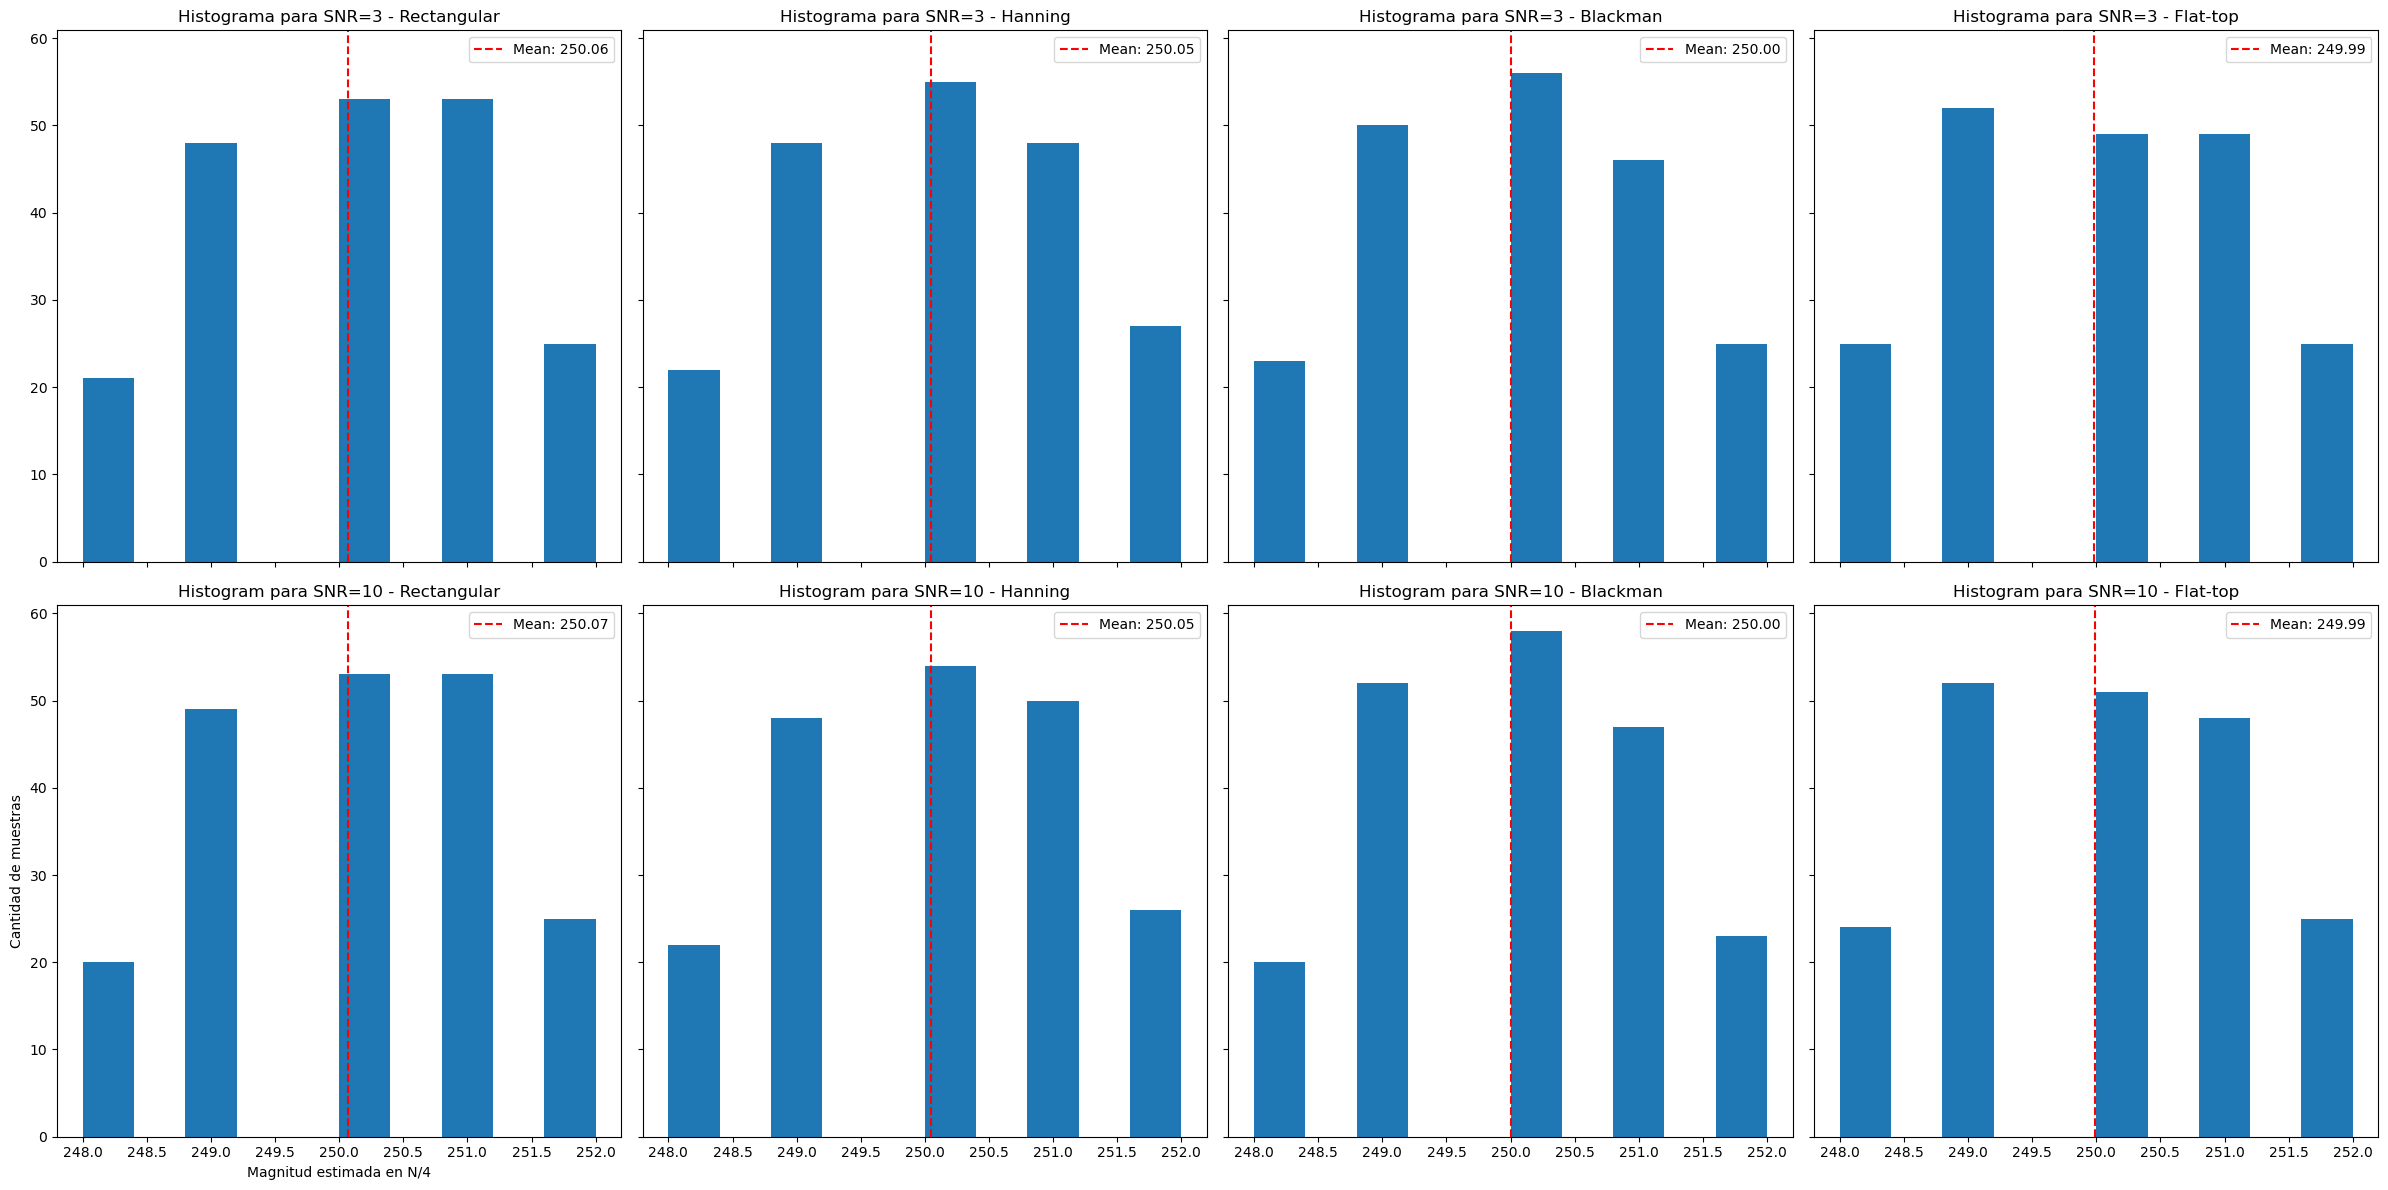

In [5]:
fig_hist, axs_hist = plt.subplots(2, 4, figsize=(24, 12), sharex=True, sharey=True)

# Histogram para SNR=3
for i, result in enumerate(results_frq_SNR_3):
    axs_hist[0, i].hist(result["Signal"], bins=bins)
    axs_hist[0, i].axvline(
        result["Estimacion"],
        color="r",
        linestyle="--",
        label=f"Mean: {result['Estimacion']:.2f}",
    )
    axs_hist[0, i].set_title(f"Histograma para SNR=3 - {result['Window']}")
    axs_hist[0, i].legend()

# Histogram para SNR=10
for i, result in enumerate(results_frq_SNR_10):
    axs_hist[1, i].hist(result["Signal"], bins=bins)
    axs_hist[1, i].axvline(
        result["Estimacion"],
        color="r",
        linestyle="--",
        label=f"Mean: {result['Estimacion']:.2f}",
    )
    axs_hist[1, i].set_title(f"Histogram para SNR=10 - {result['Window']}")
    axs_hist[1, i].legend()

axs_hist[1, 0].set_xlabel("Magnitud estimada en N/4")
axs_hist[1, 0].set_ylabel("Cantidad de muestras")
plt.tight_layout()
plt.show()

## Conclusiones del Histograma

En este análisis, se observa que los valores estimados generan un histograma muy disperso, con mayor concentración en las frecuencias 250 y 251. El valor medio es cercano al valor esperado de 250.

La varianza es mucho menor (en terminos porcentuales) que el caso de estimación de magnitud. Y el sesgo es muy bajo en relación al valor real.


In [6]:
import pandas as pd

results_df_snr3 = pd.DataFrame(results_SNR_3)
results_df_snr10 = pd.DataFrame(results_SNR_10)

results_df_snr3 = results_df_snr3.drop(columns=['Signal'])
results_df_snr10 = results_df_snr10.drop(columns=['Signal'])

print("Resultados para el estimador de modulo con SNR de 3:")
display(results_df_snr3)

print("Resultados para el estimador de modulo con SNR de 10:")
display(results_df_snr10) 


results_df_snr3 = pd.DataFrame(results_frq_SNR_3)
results_df_snr10 = pd.DataFrame(results_frq_SNR_10)

results_df_snr3 = results_df_snr3.drop(columns=['Signal'])
results_df_snr10 = results_df_snr10.drop(columns=['Signal'])

print("Resultados para el estimador de frecuencia con SNR de 3:")
display(results_df_snr3)

print("Resultados para el estimador de frecuencia con SNR de 10:")
display(results_df_snr10) 

Resultados para el estimador de modulo con SNR de 3:


,Window,Estimacion,Estimacion Corregida,Sesgo,Variance
0,Rectangular,0.720047,2.0,-1.279953,0.377501
1,Hanning,0.931700,2.0,-1.068300,0.365669
2,Blackman,1.057449,2.0,-0.942551,0.389425
3,Flat-top,1.103642,2.0,-0.896358,0.364485


Resultados para el estimador de modulo con SNR de 10:


,Window,Estimacion,Estimacion Corregida,Sesgo,Varianza
0,Rectangular,0.712533,2.0,-1.287467,0.385393
1,Hanning,0.931008,2.0,-1.068992,0.363921
2,Blackman,1.058790,2.0,-0.941210,0.392605
3,Flat-top,1.107137,2.0,-0.892863,0.361903


Resultados para el estimador de frecuencia con SNR de 3:


,Window,Estimacion,Estimacion Corregida,Sesgo,Variance
0,Rectangular,250.065,250.0,0.065,1.420775
1,Hanning,250.050,250.0,0.050,1.457500
2,Blackman,250.000,250.0,0.000,1.440000
3,Flat-top,249.985,250.0,-0.015,1.504775


Resultados para el estimador de frecuencia con SNR de 10:


,Window,Estimacion,Estimacion Corregida,Sesgo,Varianza
0,Rectangular,250.070,250.0,0.070,1.405100
1,Hanning,250.050,250.0,0.050,1.447500
2,Blackman,250.005,250.0,0.005,1.354975
3,Flat-top,249.990,250.0,-0.010,1.479900


# Conclusiones

Se aprecia que la ventana Flat-top es la mejor en este caso, su varianza y sesgo en todos los casos es menor a comparación de las demás ventanas. La ventana rectangular, no es muy práctica para estimaciones espectrales, presenta el mayor sesgo en todos los casos, en algunas situaciones la varianza es similar a otras ventanas. Si se trata de un error sistemático(sesgo) conocido, y se busca la menor varianza posible, quizás no sea tan mala opción. 